---

TABLE OF CONTENTS:
1) Match Predictive Model \
2) World Cup 2022 Predictive Model \
3) World Cup 2022 Simulation \
4) Sample Match Prediction

---

1) MATCH PREDICTIVE MODEL

In-depth analysis of a single match between selected national teams. Provides statistics, breakdown of potential results based on their probability along with visualization and winning chances for both teams.

NOTE: besides teams you can choose how much data will be utilized for analysis (start_date_wc refers to World Cup Finals and start_date_inter to all other matches)

METHODOLOGY: Model compares average numbers of goals scored/lost per match for each team with average results obtained by all of the teams in the relevant group and uses that information to calculate attack strength and defence strength values. Then attack strength of one team is multiplied by the defence strength of their opponent as well as average number of goals scored during World Cup Finals in the selected data scope in order to derive the number of expected goals for that particular match. The reason why average number of goals scored during World Cup Finals is also used as a base for calculations of expected goals (and not some kind of a mixture of averages obtained from World Cup Finals and other international matches) is that the purpose of this model is to simulate matches that will take place/could take place specifically during World Cup Finals. Finally, Poisson distribution with the number of expected goals used as an expected value is utilized to calculate the probability of different results. For simplicity of calculations assumption is made that quantities of goals scored by each team are independent. <br>
It is also important to note that statistics for World Cup matches and other international matches (friendly matches, UEFA Euro, World Cup qualification, and the rest of the tournaments) are calculated separately. Final attack/defense strength is obtained by taking the arithmetic average of both results. Moreover, indicators describing attack and defense capabilities of teams that have not participated in one or more of the World Cup Finals (from the selected scope of data) are negatively affected (logic: number of appearances in World Cup Finals is treated as a measure of how elite the team is so each failure to qualify will increase the severity of penalty).


---

In [1]:
# MATCH PREDICTIVE MODEL

# PACKAGES
import numpy as np
import pandas as pd
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# DATA
all_matches = pd.read_excel(r'C:\Users\majch\Desktop\Data Analytics\My analysis\MAVEN World Cup Challenge\Python_script\Tables\Final_tables\all_matches_w_winner_col_w_penalties_v1.xls')
international_matches = all_matches[all_matches['ID'].str[0:2] == 'IN']
worldcup_matches = all_matches[all_matches['ID'].str[0:2] == 'WC']

def match_prediction(Team1, Team2, start_date_inter = '2016-11-20', start_date_wc = '1998-01-01'):
    
    # OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (World Cup Finals matches)
        print('OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (World Cup Finals matches since',start_date_wc,')\n')
        matches_from_date_wc = worldcup_matches[worldcup_matches['Date'] >= start_date_wc]
        All_wcs_in_scope = len(matches_from_date_wc.Date.str[0:4].unique())
        print('World_Cups_in_scope', All_wcs_in_scope)
        Total_home_goals_wc = sum(matches_from_date_wc.Home_Goals)
        Total_away_goals_wc = sum(matches_from_date_wc.Away_Goals)
        Total_goals_wc = Total_home_goals_wc + Total_away_goals_wc
        print('Total_goals',Total_goals_wc)
        Total_matches_wc = len(matches_from_date_wc) * 2   
        print('Total_matches',Total_matches_wc)
        if(Total_matches_wc != 0):
            Total_goals_per_match_wc = Total_goals_wc/Total_matches_wc
            print('Total_goals_per_match',round(Total_goals_per_match_wc,2))
        else:
            Total_goals_per_match_wc = 'n/a'
            print('Total_goals_per_match',Total_goals_per_match_wc)
    
    # OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (all matches except for World Cup Finals)
        print('\nOVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (all matches except for World Cup Finals since',start_date_inter,')\n')
        matches_from_date_inter = international_matches[international_matches['Date'] >= start_date_inter]
        Total_home_goals_inter = sum(matches_from_date_inter.Home_Goals)
        Total_away_goals_inter = sum(matches_from_date_inter.Away_Goals)
        Total_goals_inter = Total_home_goals_inter + Total_away_goals_inter
        print('Total_goals',Total_goals_inter)
        Total_matches_inter = len(matches_from_date_inter) * 2   
        print('Total_matches',Total_matches_inter)
        if(Total_matches_inter != 0):
            Total_goals_per_match_inter = Total_goals_inter/Total_matches_inter
            print('Total_goals_per_match',round(Total_goals_per_match_inter,2))
        else:
            Total_goals_per_match_inter = 'n/a'
            print('Total_goals_per_match',Total_goals_per_match_inter)
        
        
        
        # Break condition (model relies on average number of goals scored during
        # World Cup Finals when expected goals are calculated so that value
        # has to be higher than 0)
        if(Total_matches_wc == 0):
            return(print('\n\nNot sufficient data for further analysis. You have to include some World Cup matches in your data scope.\
                         \n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')'))
        
        
   # STATISTICS FOR Team1
        print('\nSTATISTICS FOR', Team1,'\n')
        # WC Appearances
        Team1_wcs_attended = len(matches_from_date_wc[(matches_from_date_wc.Home_Team == Team1) | (matches_from_date_wc.Away_Team == Team1)]['Date'].str[0:4].unique())
        print(Team1,'World Cup appearances',Team1_wcs_attended,'out of',All_wcs_in_scope)
        # WC Goals scored
        Team1_home_goals_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team1])
        Team1_away_goals_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team1])
        Team1_goals_wc = Team1_home_goals_wc + Team1_away_goals_wc
        print(Team1,'goals (World Cup Finals)', Team1_goals_wc)

        # WC Goals lost
        Team1_away_goals_lost_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Away_Team == Team1])
        Team1_home_goals_lost_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Home_Team == Team1])
        Team1_goals_lost_wc = Team1_home_goals_lost_wc + Team1_away_goals_lost_wc
        print(Team1,'goals_lost (World Cup Finals)', Team1_goals_lost_wc)
       
        # WC Match count
        Team1_home_matches_wc = len(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team1])
        Team1_away_matches_wc = len(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team1])
        Team1_matches_wc = Team1_home_matches_wc + Team1_away_matches_wc                                                 
        print(Team1,'matches (World Cup Finals)',Team1_matches_wc)         
        
        # Other matches Goals scored
        Team1_home_goals_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team1])
        Team1_away_goals_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team1])
        Team1_goals_inter = Team1_home_goals_inter + Team1_away_goals_inter
        print(Team1,'goals (other matches)', Team1_goals_inter)

        # Other matches Goals lost
        Team1_away_goals_lost_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Away_Team == Team1])
        Team1_home_goals_lost_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Home_Team == Team1])
        Team1_goals_lost_inter = Team1_home_goals_lost_inter + Team1_away_goals_lost_inter
        print(Team1,'goals_lost (other matches)', Team1_goals_lost_inter)

        # Other matches Match count
        Team1_home_matches_inter = len(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team1])
        Team1_away_matches_inter = len(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team1])
        Team1_matches_inter = Team1_home_matches_inter + Team1_away_matches_inter                                                 
        print(Team1,'matches (other matches)',Team1_matches_inter,'\n') 
        
        # Break condition (in case if team has not played any matches
        # within selected timeframes then statistics of that team cannot
        # be calculated so data scope will need to be extended accordingly)
        if((Team1_matches_wc + Team1_matches_inter)  == 0):
            return(print('\n\nNot sufficient data for further analysis. At least one of the teams did not play any games in the selected data scope. Please adjust your starting dates.\
                         \n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')'))             
        
        # Basic statistics - goals scored and lost per match 
        
        # WC
        if (Team1_matches_wc != 0): 
            Team1_goals_per_match_wc = Team1_goals_wc / Team1_matches_wc
            Team1_goals_per_match_lost_wc = Team1_goals_lost_wc / Team1_matches_wc
            print(Team1,'goals_per_match (World Cup Finals)',round(Team1_goals_per_match_wc,2))
            print(Team1,'goals_per_match_lost (World Cup Finals)',round(Team1_goals_per_match_lost_wc,2))
        else: 
            Team1_goals_per_match_wc = 'n/a'
            Team1_goals_per_match_lost_wc = 'n/a'
            print(Team1,'goals_per_match (World Cup Finals)',Team1_goals_per_match_wc)
            print(Team1,'goals_per_match_lost (World Cup Finals)',Team1_goals_per_match_lost_wc)
        
        # Other
        if (Team1_matches_inter != 0): 
            Team1_goals_per_match_inter = Team1_goals_inter / Team1_matches_inter
            Team1_goals_per_match_lost_inter = Team1_goals_lost_inter / Team1_matches_inter
            print(Team1,'goals_per_match (other matches)',round(Team1_goals_per_match_inter,2))
            print(Team1,'goals_per_match_lost (other matches)',round(Team1_goals_per_match_lost_inter,2),'\n')
        else: 
            Team1_goals_per_match_inter = 'n/a'
            Team1_goals_per_match_lost_inter = 'n/a'
            print(Team1,'goals_per_match (other matches)',Team1_goals_per_match_inter)
            print(Team1,'goals_per_match_lost (other matches)',Team1_goals_per_match_lost_inter,'\n')
        
        # Main statistics - attack strength and defence strength

        # WC (penalty for missing WC finals applied)
        if((Total_goals_per_match_wc != 'n/a') and (Team1_goals_per_match_wc != 'n/a')):
            Team1_attack_str_wc = Team1_goals_per_match_wc / Total_goals_per_match_wc * (0.5 + Team1_wcs_attended / All_wcs_in_scope / 2)
            print(Team1,'attack_str (World Cup Finals)',round(Team1_attack_str_wc,2))
        else:
            Team1_attack_str_wc = 'n/a'
            print(Team1,'attack_str (World Cup Finals)',Team1_attack_str_wc)
        if((Team1_goals_per_match_lost_wc != 'n/a') and (Total_goals_per_match_wc != 'n/a')):
            Team1_defence_str_wc = Team1_goals_per_match_lost_wc / Total_goals_per_match_wc / (0.5 + Team1_wcs_attended / All_wcs_in_scope / 2)
            print(Team1,'defence_str (World Cup Finals)',round(Team1_defence_str_wc,2))
        else:
            Team1_defence_str_wc = 'n/a'
            print(Team1,'defence_str (World Cup Finals)',Team1_defence_str_wc)        
        
        # Other
        if((Team1_goals_per_match_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
            Team1_attack_str_inter = Team1_goals_per_match_inter / Total_goals_per_match_inter
            print(Team1,'attack_str (other matches)',round(Team1_attack_str_inter,2))
        else:
            Team1_attack_str_inter = 'n/a'
            print(Team1,'attack_str (other matches)',Team1_attack_str_inter)
        if((Team1_goals_per_match_lost_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
            Team1_defence_str_inter = Team1_goals_per_match_lost_inter / Total_goals_per_match_inter
            print(Team1,'defence_str (other matches)',round(Team1_defence_str_inter,2),'\n')
        else:
            Team1_defence_str_inter = 'n/a'
            print(Team1,'defence_str (other matches)',Team1_defence_str_inter,'\n')
        
        # Final statistics
        # Arithmetic average calculated as outlined in the description of
        # the model.
        # NOTE: penalty for either lack of appearances in WC Finals or lack of
        # activity on the international stage applied)
        if((Total_matches_inter != 0) and (Total_matches_wc != 0)):
            if((Team1_matches_inter != 0) and (Team1_matches_wc != 0)):
                Team1_attack_str = (Team1_attack_str_inter + Team1_attack_str_wc)/2 
                Team1_defence_str = (Team1_defence_str_inter + Team1_defence_str_wc)/2
            elif((Team1_matches_wc == 0) and (Total_matches_inter != 0)):
                Team1_attack_str = Team1_attack_str_inter/2
                Team1_defence_str = Team1_defence_str_inter*2
            elif((Team1_matches_inter == 0) and (Team1_matches_wc != 0)):  
                Team1_attack_str = Team1_attack_str_wc/2
                Team1_defence_str = Team1_defence_str_wc*2
            else:
                Team1_attack_str = 'n/a'
                Team1_defence_str = 'n/a'
        elif((Total_matches_inter != 0) and (Total_matches_wc == 0)):
            Team1_attack_str = Team1_attack_str_inter
            Team1_defence_str = Team1_defence_str_inter
        elif((Total_matches_inter == 0) and (Total_matches_wc != 0)):
            Team1_attack_str = Team1_attack_str_wc
            Team1_defence_str = Team1_defence_str_wc
        else:
            Team1_attack_str = 'n/a'
            Team1_defence_str = 'n/a'
        if(Team1_attack_str != 'n/a'):
            print(Team1,'attack_str (overall)',round(Team1_attack_str,2))
        else:
            print(Team1,'attack_str (overall)',Team1_attack_str)
        if(Team1_defence_str != 'n/a'):
            print(Team1,'defence_str (overall)',round(Team1_defence_str,2))
        else:
            print(Team1,'defence_str (overall)',Team1_defence_str)
            
   # STATISTICS FOR Team2
        print('\nSTATISTICS FOR', Team2,'\n')
        # WC Appearances
        Team2_wcs_attended = len(matches_from_date_wc[(matches_from_date_wc.Home_Team == Team2) | (matches_from_date_wc.Away_Team == Team2)]['Date'].str[0:4].unique())
        print(Team2,'World Cup appearances',Team2_wcs_attended,'out of',All_wcs_in_scope)        
        # WC Goals scored
        Team2_home_goals_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team2])
        Team2_away_goals_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team2])
        Team2_goals_wc = Team2_home_goals_wc + Team2_away_goals_wc
        print(Team2,'goals (World Cup Finals)', Team2_goals_wc)

        # WC Goals lost
        Team2_away_goals_lost_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Away_Team == Team2])
        Team2_home_goals_lost_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Home_Team == Team2])
        Team2_goals_lost_wc = Team2_home_goals_lost_wc + Team2_away_goals_lost_wc
        print(Team2,'goals_lost (World Cup Finals)', Team2_goals_lost_wc)
       
        # WC Match count
        Team2_home_matches_wc = len(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team2])
        Team2_away_matches_wc = len(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team2])
        Team2_matches_wc = Team2_home_matches_wc + Team2_away_matches_wc                                                 
        print(Team2,'matches (World Cup Finals)',Team2_matches_wc)         
        
        # Other matches Goals scored
        Team2_home_goals_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team2])
        Team2_away_goals_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team2])
        Team2_goals_inter = Team2_home_goals_inter + Team2_away_goals_inter
        print(Team2,'goals (other matches)', Team2_goals_inter)

        # Other matches Goals lost
        Team2_away_goals_lost_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Away_Team == Team2])
        Team2_home_goals_lost_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Home_Team == Team2])
        Team2_goals_lost_inter = Team2_home_goals_lost_inter + Team2_away_goals_lost_inter
        print(Team2,'goals_lost (other matches)', Team2_goals_lost_inter)

        # Other matches Match count
        Team2_home_matches_inter = len(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team2])
        Team2_away_matches_inter = len(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team2])
        Team2_matches_inter = Team2_home_matches_inter + Team2_away_matches_inter                                                 
        print(Team2,'matches (other matches)',Team2_matches_inter,'\n') 
        
        # Break condition (in case if team has not played any matches
        # within selected timeframes then statistics of that team cannot
        # be calculated so data scope will need to be extended accordingly)
        if((Team2_matches_wc + Team2_matches_inter)  == 0):
            return(print('\n\nNot sufficient data for further analysis. At least one of the teams did not play any games in the selected data scope. Please adjust your starting dates.\
                         \n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')'))            
        
        # Basic statistics - goals scored and lost per match 
        
        # WC
        if (Team2_matches_wc != 0): 
            Team2_goals_per_match_wc = Team2_goals_wc / Team2_matches_wc
            Team2_goals_per_match_lost_wc = Team2_goals_lost_wc / Team2_matches_wc
            print(Team2,'goals_per_match (World Cup Finals)',round(Team2_goals_per_match_wc,2))
            print(Team2,'goals_per_match_lost (World Cup Finals)',round(Team2_goals_per_match_lost_wc,2))
        else: 
            Team2_goals_per_match_wc = 'n/a'
            Team2_goals_per_match_lost_wc = 'n/a'
            print(Team2,'goals_per_match (World Cup Finals)',Team2_goals_per_match_wc)
            print(Team2,'goals_per_match_lost (World Cup Finals)',Team2_goals_per_match_lost_wc)
        
        # Other
        if (Team2_matches_inter != 0): 
            Team2_goals_per_match_inter = Team2_goals_inter / Team2_matches_inter
            Team2_goals_per_match_lost_inter = Team2_goals_lost_inter / Team2_matches_inter
            print(Team2,'goals_per_match (other matches)',round(Team2_goals_per_match_inter,2))
            print(Team2,'goals_per_match_lost (other matches)',round(Team2_goals_per_match_lost_inter,2),'\n')
        else: 
            Team2_goals_per_match_inter = 'n/a'
            Team2_goals_per_match_lost_inter = 'n/a'
            print(Team2,'goals_per_match (other matches)',Team2_goals_per_match_inter)
            print(Team2,'goals_per_match_lost (other matches)',Team2_goals_per_match_lost_inter,'\n')
        
        # Main statistics - attack strength and defence strength

        # WC (penalty for missing WC finals applied)
        if((Total_goals_per_match_wc != 'n/a') and (Team2_goals_per_match_wc != 'n/a')):
            Team2_attack_str_wc = Team2_goals_per_match_wc / Total_goals_per_match_wc * (0.5 + Team2_wcs_attended / All_wcs_in_scope / 2)
            print(Team2,'attack_str (World Cup Finals)',round(Team2_attack_str_wc,2))
        else:
            Team2_attack_str_wc = 'n/a'
            print(Team2,'attack_str (World Cup Finals)',Team2_attack_str_wc)
        if((Team2_goals_per_match_lost_wc != 'n/a') and (Total_goals_per_match_wc != 'n/a')):
            Team2_defence_str_wc = Team2_goals_per_match_lost_wc / Total_goals_per_match_wc / (0.5 + Team2_wcs_attended / All_wcs_in_scope / 2)
            print(Team2,'defence_str (World Cup Finals)',round(Team2_defence_str_wc,2))
        else:
            Team2_defence_str_wc = 'n/a'
            print(Team2,'defence_str (World Cup Finals)',Team2_defence_str_wc)        
        
        # Other
        if((Team2_goals_per_match_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
            Team2_attack_str_inter = Team2_goals_per_match_inter / Total_goals_per_match_inter
            print(Team2,'attack_str (other matches)',round(Team2_attack_str_inter,2))
        else:
            Team2_attack_str_inter = 'n/a'
            print(Team2,'attack_str (other matches)',Team2_attack_str_inter)
        if((Team2_goals_per_match_lost_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
            Team2_defence_str_inter = Team2_goals_per_match_lost_inter / Total_goals_per_match_inter
            print(Team2,'defence_str (other matches)',round(Team2_defence_str_inter,2),'\n')
        else:
            Team2_defence_str_inter = 'n/a'
            print(Team2,'defence_str (other matches)',Team2_defence_str_inter,'\n')
        
        # Final statistics
        # Arithmetic average calculated as outlined in the description of
        # the model.
        # NOTE: penalty for either lack of appearances in WC Finals or lack of
        # activity on the international stage applied)
        if((Total_matches_inter != 0) and (Total_matches_wc != 0)):
            if((Team2_matches_inter != 0) and (Team2_matches_wc != 0)):
                Team2_attack_str = (Team2_attack_str_inter + Team2_attack_str_wc)/2 
                Team2_defence_str = (Team2_defence_str_inter + Team2_defence_str_wc)/2
            elif((Team2_matches_wc == 0) and (Total_matches_inter != 0)):
                Team2_attack_str = Team2_attack_str_inter/2
                Team2_defence_str = Team2_defence_str_inter*2
            elif((Team2_matches_inter == 0) and (Team2_matches_wc != 0)):  
                Team2_attack_str = Team2_attack_str_wc/2
                Team2_defence_str = Team2_defence_str_wc*2
            else:
                Team2_attack_str = 'n/a'
                Team2_defence_str = 'n/a'
        elif((Total_matches_inter != 0) and (Total_matches_wc == 0)):
            Team2_attack_str = Team2_attack_str_inter
            Team2_defence_str = Team2_defence_str_inter
        elif((Total_matches_inter == 0) and (Total_matches_wc != 0)):
            Team2_attack_str = Team2_attack_str_wc
            Team2_defence_str = Team2_defence_str_wc
        else:
            Team2_attack_str = 'n/a'
            Team2_defence_str = 'n/a'
        if(Team2_attack_str != 'n/a'):
            print(Team2,'attack_str (overall)',round(Team2_attack_str,2))
        else:
            print(Team2,'attack_str (overall)',Team2_attack_str)
        if(Team2_defence_str != 'n/a'):
            print(Team2,'defence_str (overall)',round(Team2_defence_str,2))
        else:
            print(Team2,'defence_str (overall)',Team2_defence_str)
            
    # RESULT PREDICTION 
        # Expected goals
        # Total_goals_per_match_wc used in calculations as prediction concerns World Cup matches
        print('\nEXPECTED GOALS\n')
        
        # Team 1
        if(Team1_attack_str != 'n/a' and Team2_defence_str != 'n/a' and Total_goals_per_match_wc != 'n/a'):
            Team1_goal_exp = Team1_attack_str * Team2_defence_str * Total_goals_per_match_wc
            print(Team1,'goal_exp',round(Team1_goal_exp,2))
        else:
            Team1_goal_exp = 'n/a'
            print(Team1,'goal_exp',Team1_goal_exp)
        
        # Team 2
        if(Team2_attack_str != 'n/a' and Team1_defence_str != 'n/a' and Total_goals_per_match_wc != 'n/a'):
            Team2_goal_exp = Team2_attack_str * Team1_defence_str * Total_goals_per_match_wc
            print(Team2,'goal_exp',round(Team2_goal_exp,2))
        else:
            Team2_goal_exp = 'n/a'
            print(Team2,'goal_exp',Team2_goal_exp)
        
        # Probability distribution for number of goals scored by each team based on 
        # Poisson distribution
        print('\nPROBABILITY OF SCORING FOR EACH TEAM\n')
        Team1_results = list()
        Team2_results = list()
        Team1_Team2_results = pd.DataFrame(list())
        Team1_results = poisson.pmf(np.arange(0,101),Team1_goal_exp)
        Team2_results = poisson.pmf(np.arange(0,101),Team2_goal_exp)
        Team1_sum_6_100 = sum(Team1_results[6:101])
        Team2_sum_6_100 = sum(Team2_results[6:101])
        Team1_Team2_results[Team1] = Team1_results[0:7]
        Team1_Team2_results.loc[6,Team1] = Team1_sum_6_100
        Team1_Team2_results[Team2] = Team2_results[0:7]
        Team1_Team2_results.loc[6,Team2] = Team2_sum_6_100
        Team1_Team2_results.index = [0,1,2,3,4,5,'6+']
        print(Team1_Team2_results)
        Team1_Team2_results.index = np.arange(0,7)
        # Probability table for potential match results
        # NOTE: For simplicity of calculations assumption is made that 
        # number of goals scored by each team is independent
        # print('\nPROBABILITY DISTRIBUTION OF POTENTIAL RESULTS\n')
        Team1_arr = np.array(Team1_Team2_results[Team1])
        Team2_arr = np.array(Team1_Team2_results[Team2])
        Team1_Team2_results_prob = pd.DataFrame(np.outer(Team1_arr, Team2_arr))
        # print(Team1_Team2_results_prob)
        # Visualization
        print('\nVISUALIZATION\n')
        sns.set_style('whitegrid')
        f, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8,8))
        axes[0].bar(x = Team1_Team2_results[Team1].index, height = Team1_Team2_results[Team1].values, width = -0.4, align = 'edge')
        axes[0].bar(x = Team1_Team2_results[Team2].index, height = Team1_Team2_results[Team2].values, width = 0.4, align = 'edge', tick_label = [0,1,2,3,4,5,'6+'])
        axes[0].legend(Team1_Team2_results.columns)
        axes[0].set_xlabel('Number of goals')
        axes[0].set_ylabel('Probability')
        axes[0].set_title('PROBABILITY OF SCORING FOR EACH TEAM')
        heat = sns.heatmap(Team1_Team2_results_prob, annot=True, ax = axes[1], xticklabels = [0,1,2,3,4,5,'6+'], yticklabels = [0,1,2,3,4,5,'6+'])
        axes[1].set_xlabel(Team2 + ' (Goals)')
        axes[1].set_ylabel(Team1 + ' (Goals)')
        axes[1].set_title('PROBABILITY DISTRIBUTION OF POTENTIAL RESULTS')
        f.tight_layout()
        plt.show()
        # Final result estimation (winning/drawing chances for both teams)
        Team1_win_prob = 0
        Team2_win_prob = 0
        Draw_prob = 0
        for i in np.arange(0,7):
            for j in np.arange(0,7):
                if(i>j): 
                    Team2_win_prob = Team2_win_prob + Team1_Team2_results_prob[i][j]
                if(i<j): 
                    Team1_win_prob = Team1_win_prob + Team1_Team2_results_prob[i][j]
                if(i==j): 
                    Draw_prob = Draw_prob + Team1_Team2_results_prob[i][j]
        # NOTE: Team1_Team2_results_prob uses numbers from 0 to 5 as aliases
        # for rows and columns. As a result, Team1_Team2_results_prob[i][j]
        # expression refers to column with alias 'i' and row with alias 'j'
        
        print('\nWINNING CHANCES\n')
        print(Team1,'win_prob', round(Team1_win_prob,2))
        print(Team2,'win_prob', round(Team2_win_prob,2))
        print('Draw prob ', round(Draw_prob,2))

    # Information about function parameters
        print('\n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')')

---

2) WORLD CUP 2022 PREDICTIVE MODEL

Returns the most likely outcome of every single match during World Cup 2022 Finals based on historical data (medalists are determined).

NOTE: You can choose how much data will be utilized for analysis (start_date_wc refers to World Cup Finals and start_date_inter to all other matches). Default settings are the following: 1) start date for World Cup Finals is set to 1998-01-01 what means that data from six consecutive tournaments that were organized before World Cup Finals from 2022 will be taken into account 2) start date for other international matches is set to 2016-11-20, so all matches that took place during six-year period preceding World Cup Finals in Qatar will be considered. This particular setup was used in my own simulation (results along with three more charts are to be found in my dashboard for football fans that I prepared in Tableau Public). Appearances and results obtained during World Cup Finals indicate how well national teams perform during the most prestigious tournament and what their true capabilities are given that they have to face the best teams from all over the world (among other information). On the other hand, their performance in matches outside of World Cup Finals from the past few years is supposed to provide information about the current form of teams. However, you are encouraged to modify these dates to your liking and see how the change affects results of the simulation.

METHODOLOGY: The same methodology as in the case of 'Match Predictive Model' is utilized. However, in this model the most probable outcome of each match is used as a result for further simulation. During the playoffs model does not take into account a draw as a potential result and instead returns the team with higher odds of winning as one would expect. In order to ensure that the model always returns relevant results, the following tiebreakers were implemented:<br>
1. If two teams or more in a group collected exactly the same number of points then the model would consider a direct match between each pair of these teams and would compare winning chances to establish which team should be placed higher in the group standings. Due to mathematical transitivity (Team1_win_prob > Team2_win_prob and Team2_win_prob > Team3_win_prob then Team1_win_prob > Team3_win_prob) this approach provides final and unambiguous result. In the future model might be extended to keep track of the most likely goal counts or expected goals for each match and use these metrics to determine the group standings but for now the solution outlined above is in use due to its simplicity, low likelihood of situation where two or more teams have the same number of points (mentioned transitivity and the fact that draws are rarely the most probable outcome of matches), and lastly because it provides good estimate of the standings without the necessity of implementing further tiebreakers. For example, if goal differences were used as a tiebreaker then we might end up in a situation where two or even more teams have exactly the same results which would require implementation of additional solutions (in fact, FIFA prepared a list composed of seven tiebreakers starting from goal differences and finishing with drawing of lots to resolve potential ties!).
2. In case of a match between two teams in a group stage with no explicit favourite (odds of winning for neither of the teams are higher than odds of winning for their opponent as well as odds of a draw) model will return draw as an outcome.
3. If the model compares the winning chances of two teams in a scenario where draws are not taken into account (e.g. playoffs) and these odds turn out to be equal (an extremely rare situation), then the FIFA ranking will be used as the final decider. For example, if England (ranked 5th in the FIFA ranking) were to play France (ranked 4th) in the quarter-finals and the winning chances of both teams were exactly the same, then France would advance further.

---

In [2]:
# WORLD CUP 2022 PREDICTIVE MODEL

# PACKAGES
import numpy as np
import pandas as pd
from scipy.stats import poisson
pd.set_option('display.max.rows',None) # all of the results visible at once

# DATA
all_matches = pd.read_excel(r'C:\Users\majch\Desktop\Data Analytics\My analysis\MAVEN World Cup Challenge\Python_script\Tables\Final_tables\all_matches_w_winner_col_w_penalties_v1.xls')
international_matches = all_matches[all_matches['ID'].str[0:2] == 'IN']
worldcup_matches = all_matches[all_matches['ID'].str[0:2] == 'WC']
match_schedule = pd.read_csv(r'C:\Users\majch\Desktop\Data Analytics\My analysis\MAVEN World Cup Challenge\Python_script\Tables\Final_tables\2022_world_cup_matches.csv')
wc_groups = pd.read_csv(r'C:\Users\majch\Desktop\Data Analytics\My analysis\MAVEN World Cup Challenge\Python_script\Tables\Final_tables\2022_world_cup_groups.csv')


def world_cup_prediction(start_date_inter = '2016-11-20', start_date_wc = '1998-01-01'):

    # DEFINING TABLES THAT WILL BE POPULATED WITH RESULTS (we not only want
    # to make use of them within our function but also to have access to them
    # once simulation is completed)
    global match_schedule_upd
    global wc_groups_upd
    match_schedule_upd = match_schedule.copy()
    wc_groups_upd = wc_groups.copy()
   
    # OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (World Cup Finals)
    matches_from_date_wc = worldcup_matches[worldcup_matches['Date'] >= start_date_wc]
    All_wcs_in_scope = len(matches_from_date_wc.Date.str[0:4].unique())
    Total_home_goals_wc = sum(matches_from_date_wc.Home_Goals)
    Total_away_goals_wc = sum(matches_from_date_wc.Away_Goals)
    Total_goals_wc = Total_home_goals_wc + Total_away_goals_wc
    Total_matches_wc = len(matches_from_date_wc) * 2   
    if(Total_matches_wc != 0):
        Total_goals_per_match_wc = Total_goals_wc/Total_matches_wc
    else:
        Total_goals_per_match_wc = 'n/a'       
    
    # OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (all matches except for World Cup Finals)
    matches_from_date_inter = international_matches[international_matches['Date'] >= start_date_inter]
    Total_home_goals_inter = sum(matches_from_date_inter.Home_Goals)
    Total_away_goals_inter = sum(matches_from_date_inter.Away_Goals)
    Total_goals_inter = Total_home_goals_inter + Total_away_goals_inter
    Total_matches_inter = len(matches_from_date_inter) * 2   
    if(Total_matches_inter != 0):
        Total_goals_per_match_inter = Total_goals_inter/Total_matches_inter
    else:
        Total_goals_per_match_inter = 'n/a'

    # Break condition (model relies on average number of goals scored during
    # World Cup Finals when expected goals are calculated so that value
    # has to be higher than 0)
    if(Total_matches_wc == 0):
        return(print('\n\nNot sufficient data for further analysis. You have to include some World Cup matches in your data scope.\
                     \n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')'))

    def match_result(Team1, Team2, Draw = True): 
        
        # Function returns the most probable outcome of a match between the
        # teams that were selected
        
        # Note 1: function based on 'Match Predictive Model' described earlier
        # with some modifications that are necessary for the purposes of
        # 'World Cup Predictive Model'
        # Note 2: Draw parameter determines if draw is acceptable as a result of
        # a match or not (in playoffs one team has to win and advance further)
        
        # STATISTICS FOR Team1
            # WC Appearances
            Team1_wcs_attended = len(matches_from_date_wc[(matches_from_date_wc.Home_Team == Team1) | (matches_from_date_wc.Away_Team == Team1)]['Date'].str[0:4].unique())
            # WC Goals scored
            Team1_home_goals_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team1])
            Team1_away_goals_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team1])
            Team1_goals_wc = Team1_home_goals_wc + Team1_away_goals_wc

            # WC Goals lost
            Team1_away_goals_lost_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Away_Team == Team1])
            Team1_home_goals_lost_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Home_Team == Team1])
            Team1_goals_lost_wc = Team1_home_goals_lost_wc + Team1_away_goals_lost_wc

            # WC Match count
            Team1_home_matches_wc = len(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team1])
            Team1_away_matches_wc = len(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team1])
            Team1_matches_wc = Team1_home_matches_wc + Team1_away_matches_wc                                                         

            # Other matches Goals scored
            Team1_home_goals_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team1])
            Team1_away_goals_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team1])
            Team1_goals_inter = Team1_home_goals_inter + Team1_away_goals_inter

            # Other matches Goals lost
            Team1_away_goals_lost_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Away_Team == Team1])
            Team1_home_goals_lost_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Home_Team == Team1])
            Team1_goals_lost_inter = Team1_home_goals_lost_inter + Team1_away_goals_lost_inter

            # Other matches Match count
            Team1_home_matches_inter = len(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team1])
            Team1_away_matches_inter = len(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team1])
            Team1_matches_inter = Team1_home_matches_inter + Team1_away_matches_inter                                                  

            # Break condition (in case if team has not played any matches
            # within selected timeframes then statistics of that team cannot
            # be calculated so data scope will need to be extended accordingly)
            if((Team1_matches_wc + Team1_matches_inter)  == 0):
                return('break')            
            
            # Basic statistics - goals scored and lost per match 
            
            # WC
            if (Team1_matches_wc != 0): 
                Team1_goals_per_match_wc = Team1_goals_wc / Team1_matches_wc
                Team1_goals_per_match_lost_wc = Team1_goals_lost_wc / Team1_matches_wc
            else: 
                Team1_goals_per_match_wc = 'n/a'
                Team1_goals_per_match_lost_wc = 'n/a'
            
            # Other
            if (Team1_matches_inter != 0): 
                Team1_goals_per_match_inter = Team1_goals_inter / Team1_matches_inter
                Team1_goals_per_match_lost_inter = Team1_goals_lost_inter / Team1_matches_inter
            else: 
                Team1_goals_per_match_inter = 'n/a'
                Team1_goals_per_match_lost_inter = 'n/a'

            # Main statistics - attack strength and defence strength

            # WC (penalty for missing WC finals applied)
            if((Total_goals_per_match_wc != 'n/a') and (Team1_goals_per_match_wc != 'n/a')):
                Team1_attack_str_wc = Team1_goals_per_match_wc / Total_goals_per_match_wc * (0.5 + Team1_wcs_attended / All_wcs_in_scope / 2)
            else:
                Team1_attack_str_wc = 'n/a'
            if((Team1_goals_per_match_lost_wc != 'n/a') and (Total_goals_per_match_wc != 'n/a')):
                Team1_defence_str_wc = Team1_goals_per_match_lost_wc / Total_goals_per_match_wc / (0.5 + Team1_wcs_attended / All_wcs_in_scope / 2)
            else:
                Team1_defence_str_wc = 'n/a' 
            
            # Other
            if((Team1_goals_per_match_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
                Team1_attack_str_inter = Team1_goals_per_match_inter / Total_goals_per_match_inter
            else:
                Team1_attack_str_inter = 'n/a'
            if((Team1_goals_per_match_lost_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
                Team1_defence_str_inter = Team1_goals_per_match_lost_inter / Total_goals_per_match_inter
            else:
                Team1_defence_str_inter = 'n/a'
            
            # Final statistics
            # Arithmetic average calculated as outlined in the description of
            # the model.
            # NOTE: penalty for either lack of appearances in WC Finals or lack of
            # activity on the international stage applied)
            if((Total_matches_inter != 0) and (Total_matches_wc != 0)):
                if((Team1_matches_inter != 0) and (Team1_matches_wc != 0)):
                    Team1_attack_str = (Team1_attack_str_inter + Team1_attack_str_wc)/2 
                    Team1_defence_str = (Team1_defence_str_inter + Team1_defence_str_wc)/2
                elif((Team1_matches_wc == 0) and (Total_matches_inter != 0)):
                    Team1_attack_str = Team1_attack_str_inter/2
                    Team1_defence_str = Team1_defence_str_inter*2
                elif((Team1_matches_inter == 0) and (Team1_matches_wc != 0)):  
                    Team1_attack_str = Team1_attack_str_wc/2
                    Team1_defence_str = Team1_defence_str_wc*2
                else:
                    Team1_attack_str = 'n/a'
                    Team1_defence_str = 'n/a'
            elif((Total_matches_inter != 0) and (Total_matches_wc == 0)):
                Team1_attack_str = Team1_attack_str_inter
                Team1_defence_str = Team1_defence_str_inter
            elif((Total_matches_inter == 0) and (Total_matches_wc != 0)):
                Team1_attack_str = Team1_attack_str_wc
                Team1_defence_str = Team1_defence_str_wc
            else:
                Team1_attack_str = 'n/a'
                Team1_defence_str = 'n/a'

        # STATISTICS FOR Team2
            # WC Appearances
            Team2_wcs_attended = len(matches_from_date_wc[(matches_from_date_wc.Home_Team == Team2) | (matches_from_date_wc.Away_Team == Team2)]['Date'].str[0:4].unique())
            # WC Goals scored
            Team2_home_goals_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team2])
            Team2_away_goals_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team2])
            Team2_goals_wc = Team2_home_goals_wc + Team2_away_goals_wc

            # WC Goals lost
            Team2_away_goals_lost_wc = sum(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Away_Team == Team2])
            Team2_home_goals_lost_wc = sum(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Home_Team == Team2])
            Team2_goals_lost_wc = Team2_home_goals_lost_wc + Team2_away_goals_lost_wc

            # WC Match count
            Team2_home_matches_wc = len(matches_from_date_wc['Home_Goals'][matches_from_date_wc.Home_Team == Team2])
            Team2_away_matches_wc = len(matches_from_date_wc['Away_Goals'][matches_from_date_wc.Away_Team == Team2])
            Team2_matches_wc = Team2_home_matches_wc + Team2_away_matches_wc                                                        

            # Other matches Goals scored
            Team2_home_goals_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team2])
            Team2_away_goals_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team2])
            Team2_goals_inter = Team2_home_goals_inter + Team2_away_goals_inter

            # Other matches Goals lost
            Team2_away_goals_lost_inter = sum(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Away_Team == Team2])
            Team2_home_goals_lost_inter = sum(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Home_Team == Team2])
            Team2_goals_lost_inter = Team2_home_goals_lost_inter + Team2_away_goals_lost_inter

            # Other matches Match count
            Team2_home_matches_inter = len(matches_from_date_inter['Home_Goals'][matches_from_date_inter.Home_Team == Team2])
            Team2_away_matches_inter = len(matches_from_date_inter['Away_Goals'][matches_from_date_inter.Away_Team == Team2])
            Team2_matches_inter = Team2_home_matches_inter + Team2_away_matches_inter                                                 

            # Break condition (in case if team has not played any matches
            # within selected timeframes then statistics of that team cannot
            # be calculated so data scope will need to be extended accordingly)
            if((Team2_matches_wc + Team2_matches_inter)  == 0):
                return('break')                        

            # Basic statistics - goals scored and lost per match 
            
            # WC
            if (Team2_matches_wc != 0): 
                Team2_goals_per_match_wc = Team2_goals_wc / Team2_matches_wc
                Team2_goals_per_match_lost_wc = Team2_goals_lost_wc / Team2_matches_wc
            else: 
                Team2_goals_per_match_wc = 'n/a'
                Team2_goals_per_match_lost_wc = 'n/a'
            
            # Other
            if (Team2_matches_inter != 0): 
                Team2_goals_per_match_inter = Team2_goals_inter / Team2_matches_inter
                Team2_goals_per_match_lost_inter = Team2_goals_lost_inter / Team2_matches_inter
            else: 
                Team2_goals_per_match_inter = 'n/a'
                Team2_goals_per_match_lost_inter = 'n/a'

            # Main statistics - attack strength and defence strength

            # WC (penalty for missing WC finals applied)
            if((Total_goals_per_match_wc != 'n/a') and (Team2_goals_per_match_wc != 'n/a')):
                Team2_attack_str_wc = Team2_goals_per_match_wc / Total_goals_per_match_wc * (0.5 + Team2_wcs_attended / All_wcs_in_scope / 2)
            else:
                Team2_attack_str_wc = 'n/a'
            if((Team2_goals_per_match_lost_wc != 'n/a') and (Total_goals_per_match_wc != 'n/a')):
                Team2_defence_str_wc = Team2_goals_per_match_lost_wc / Total_goals_per_match_wc / (0.5 + Team2_wcs_attended / All_wcs_in_scope / 2)
            else:
                Team2_defence_str_wc = 'n/a' 
            
            # Other
            if((Team2_goals_per_match_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
                Team2_attack_str_inter = Team2_goals_per_match_inter / Total_goals_per_match_inter
            else:
                Team2_attack_str_inter = 'n/a'
            if((Team2_goals_per_match_lost_inter != 'n/a') and (Total_goals_per_match_inter != 'n/a')):
                Team2_defence_str_inter = Team2_goals_per_match_lost_inter / Total_goals_per_match_inter
            else:
                Team2_defence_str_inter = 'n/a'
            
            # Final statistics
            # Arithmetic average calculated as outlined in the description of
            # the model.
            # NOTE: penalty for either lack of appearances in WC Finals or lack of
            # activity on the international stage applied)
            if((Total_matches_inter != 0) and (Total_matches_wc != 0)):
                if((Team2_matches_inter != 0) and (Team2_matches_wc != 0)):
                    Team2_attack_str = (Team2_attack_str_inter + Team2_attack_str_wc)/2 
                    Team2_defence_str = (Team2_defence_str_inter + Team2_defence_str_wc)/2
                elif((Team2_matches_wc == 0) and (Total_matches_inter != 0)):
                    Team2_attack_str = Team2_attack_str_inter/2
                    Team2_defence_str = Team2_defence_str_inter*2
                elif((Team2_matches_inter == 0) and (Team2_matches_wc != 0)):  
                    Team2_attack_str = Team2_attack_str_wc/2
                    Team2_defence_str = Team2_defence_str_wc*2
                else:
                    Team2_attack_str = 'n/a'
                    Team2_defence_str = 'n/a'
            elif((Total_matches_inter != 0) and (Total_matches_wc == 0)):
                Team2_attack_str = Team2_attack_str_inter
                Team2_defence_str = Team2_defence_str_inter
            elif((Total_matches_inter == 0) and (Total_matches_wc != 0)):
                Team2_attack_str = Team2_attack_str_wc
                Team2_defence_str = Team2_defence_str_wc
            else:
                Team2_attack_str = 'n/a'
                Team2_defence_str = 'n/a'

        # RESULT PREDICTION 
            # Expected goals
            # Total_goals_per_match_wc used in calculations as prediction concerns World Cup matches
            
            # Team1
            if(Team1_attack_str != 'n/a' and Team2_defence_str != 'n/a' and Total_goals_per_match_wc != 'n/a'):
                Team1_goal_exp = Team1_attack_str * Team2_defence_str * Total_goals_per_match_wc
            else:
                Team1_goal_exp = 'n/a'
            
            # Team2
            if(Team2_attack_str != 'n/a' and Team1_defence_str != 'n/a' and Total_goals_per_match_wc != 'n/a'):
                Team2_goal_exp = Team2_attack_str * Team1_defence_str * Total_goals_per_match_wc
            else:
                Team2_goal_exp = 'n/a'

            # Probability distribution for number of goals scored by each team based on 
            # Poisson distribution
            Team1_Team2_results = pd.DataFrame(list())
            Team1_Team2_results[Team1] = poisson.pmf(np.arange(0,11),Team1_goal_exp)
            Team1_Team2_results[Team2] = poisson.pmf(np.arange(0,11),Team2_goal_exp)
            
            # Probability table for potential match results
            # NOTE: For simplicity of calculations assumption is made that 
            # number of goals scored by each team is independent
            Team1_arr = np.array(Team1_Team2_results[Team1])
            Team2_arr = np.array(Team1_Team2_results[Team2])
            Team1_Team2_results_prob = pd.DataFrame(np.outer(Team1_arr, Team2_arr))

            # Final result estimation (winning/drawing chances for both teams)
            Team1_win_prob = 0
            Team2_win_prob = 0
            Draw_prob = 0
            for i in np.arange(0,11):
                for j in np.arange(0,11):
                    if(i>j): 
                        Team2_win_prob = Team2_win_prob + Team1_Team2_results_prob[i][j]
                    if(i<j): 
                        Team1_win_prob = Team1_win_prob + Team1_Team2_results_prob[i][j]
                    if(i==j): 
                        Draw_prob = Draw_prob + Team1_Team2_results_prob[i][j]
            # NOTE: Team1_Team2_results_prob uses numbers from 0 to 10 as aliases
            # for rows and columns. As a result, Team1_Team2_results_prob[i][j]
            # expression refers to column with alias 'i' and row with alias 'j'
            
            # Variant 1: Draw is acceptable as a result
            if(Draw == True): 
                if(Team1_win_prob > Team2_win_prob and Team1_win_prob > Draw_prob):
                    result = Team1
                elif(Team1_win_prob < Team2_win_prob and Team2_win_prob > Draw_prob):
                    result = Team2
                # In the remaining scenarios (draw is the most likely result, 
                # draw_prob == Team1/Team2_win_prob and draw_prob > Team2/Team_win_prob,
                # Team1_win_prob == Team2_win_prob and Team1_win_prob >= draw_prob)
                # draw will be considered as a result
                else:
                    result = 'Draw'
                return result
                
                # Alternative approach - drawing of lots for each scenario
                #elif(Team1_win_prob == Team2_win_prob and Team1_win_prob >= Draw_prob):
                #    if(np.random.randn() >= 0):
                #        result = Team1
                #    else:
                #        result = Team2
                #elif(Team1_win_prob == Draw_prob and Team1_win_prob > Team2_win_prob):
                #    if(np.random.randn() >= 0):
                #        result = Team1
                #    else:
                #        result = 'Draw'  
                #elif(Team2_win_prob == Draw_prob and Team1_win_prob < Team2_win_prob):
                #    if(np.random.randn() >= 0):
                #        result = Team2
                #    else:
                #        result = 'Draw'                                      
            
            # Variant 2: Draw is NOT acceptable as a result
            elif(Draw == False):
                if(Team1_win_prob > Team2_win_prob):
                    result = Team1
                elif(Team1_win_prob < Team2_win_prob):
                    result = Team2
                # Coinflip scenario - in case if winning chances are exactly
                # the same and one team has to advance model will look up
                # FIFA rankings of both teams and declare the one which
                # is higher in that ranking as the winner
                elif(Team1_win_prob == Team2_win_prob):
                    Team1_rank = wc_groups[wc_groups['Team'] == Team1]['FIFA Ranking'].item()
                    Team2_rank = wc_groups[wc_groups['Team'] == Team2]['FIFA Ranking'].item()
                    if(Team1_rank < Team2_rank):
                        result = Team1
                    else:
                        result = Team2
                return result
            
                # Alternative approach - drawing of lots
                #elif(Team1_win_prob == Team2_win_prob):
                #    if(np.random.randn() >= 0):
                #        result = Team1
                #    else:
                #        result = Team2

                

    # DETERMINING THE MOST LIKELY CONCLUSIONS OF THE MATCHES IN THE GROUP STAGE
    match_results = []
    for match in match_schedule[match_schedule['Stage'] == 'Group stage']['ID']:
        group_result = match_result(Team1 = match_schedule[match_schedule['ID']==match]['Home Team'].item(), Team2 = match_schedule[match_schedule['ID']==match]['Away Team'].item())
        # Break condition (if any team has not played a single match within selected timeframes) )
        if(group_result == 'break'):
            return(print('\n\nNot sufficient data for further analysis. At least one of the teams did not play any games in the selected data scope. Please adjust your starting dates.\
                         \n\nFunction parameters: Team1, Team2, start_date_inter (def=\'2016-11-20\'), start_date_wc (def=\'1998-01-01\')'))            
        else:  
            match_results.append(group_result)

    # INCLUSION OF THE RESULTS FROM THE GROUP STAGE AND ASSOCIATED POINT AWARDS 
    # IN MATCH_SCHEDULE_UPD TABLE
    
    match_schedule_upd['Match_results'] =  pd.DataFrame(match_results)
    
    i = 0
    Home_team_pts = []
    Away_team_pts = []
    for team in match_schedule_upd[match_schedule_upd['Stage']=='Group stage']['Home Team']:
        if team == match_schedule_upd['Match_results'][i]: 
            Home_team_pts.append(3)
            Away_team_pts.append(0)
        elif match_schedule_upd['Match_results'][i] == 'Draw': 
            Home_team_pts.append(1)
            Away_team_pts.append(1)
        elif match_schedule_upd['Away Team'][i] == match_schedule_upd['Match_results'][i]: 
            Home_team_pts.append(0)
            Away_team_pts.append(3)
        else:
            return(print('\nError related to the process of assigning points after a match in the group stage'))
        i = i + 1
    match_schedule_upd['Home_team_pts'] = pd.DataFrame(Home_team_pts)
    match_schedule_upd['Away_team_pts'] = pd.DataFrame(Away_team_pts)
    
    # FINAL POINT COUNTING AFTER COMPLETION OF THE GROUP STAGE 
    points = []
    for team in wc_groups_upd['Team']:
        points.append((match_schedule_upd[match_schedule_upd['Home Team'] == team]['Home_team_pts'].sum()) \
                      +(match_schedule_upd[match_schedule_upd['Away Team'] == team]['Away_team_pts'].sum()))
    wc_groups_upd['Points'] = pd.DataFrame(points).astype('int32')
    
    # INCLUSION OF INFORMATION ABOUT GROUP STANDINGS IN THE FOLLOWING FORMAT: 
    # place + group letter (e.g. 2B for 2nd place in group B) to be consistent
    # with convention used in match_schedule table to denote pairings 
    # in Round of 16 stage
    wc_groups_upd = wc_groups_upd.sort_values(['Group','Points'],ascending = [True,False])
    wc_groups_upd.index = np.arange(0,32) # re-indexing required as sorting
    # applies to original index values as well
    wc_groups_upd['Place'] = pd.Series([1,2,3,4] * 8).astype('string') + wc_groups_upd['Group']
    
    # Tiebreaker rule for instances when two or more teams in a group
    # have the same number of points - for each two teams that have the
    # same number of points model will compare winning chances for both of
    # them in a direct match and move up the team with higher odds
    # NOTE: 3 iterations used in case if all four teams got the same number
    # of points
    for sorting_iteration in [1,2,3]:
        for i in np.arange(0,len(wc_groups_upd)-1):
            if((wc_groups_upd['Group'][i] == wc_groups_upd['Group'][i+1])\
               & (wc_groups_upd['Points'][i] == wc_groups_upd['Points'][i+1])):
                tie_breaker = match_result(Team1 = wc_groups_upd['Team'][i], Team2 = wc_groups_upd['Team'][i+1], Draw = False)
                if(tie_breaker == wc_groups_upd['Team'][i+1]):
                    team1_place = wc_groups_upd['Place'][i]
                    wc_groups_upd['Place'][i] = wc_groups_upd['Place'][i+1]
                    wc_groups_upd['Place'][i+1] = team1_place
    wc_groups_upd = wc_groups_upd.sort_values(['Group','Place'],ascending = [True,True])
    wc_groups_upd.index = np.arange(0,32) # re-indexing required as sorting
    # applies to original index values as well
    
    # SIMULATION FOR ROUND OF 16
    # NOTE 1: The most probable winner advances further (as outlined earlier)
    # NOTE 2: raw match_schedule table used to ensure access to original pairings
    # NOTE 3: match ID is assigned from 1 upward and equals value of record index + 1
    for match_id in match_schedule_upd[match_schedule_upd['Stage'] == 'Round of 16']['ID']:
        match_schedule_upd.loc[match_id-1,'Home Team'] = wc_groups_upd[wc_groups_upd['Place']==match_schedule.loc[match_id-1,'Home Team']]['Team'].item()
        match_schedule_upd.loc[match_id-1,'Away Team'] = wc_groups_upd[wc_groups_upd['Place']==match_schedule.loc[match_id-1,'Away Team']]['Team'].item()
        match_schedule_upd.loc[match_id-1,'Match_results'] = match_result(Team1 = match_schedule_upd.loc[match_id-1,'Home Team'], Team2 = match_schedule_upd.loc[match_id-1,'Away Team'], Draw = False)

    # SIMULATION FOR QUARTER-FINALS AND NEXT STAGES UP TO THE FINAL OF WORLD CUP
    # NOTE 1: The most probable winner advances further
    # NOTE 2: winners/losers from previous stage are denoted using the 
    # following convention: W/L + match ID (e.g. W61)
    # NOTE 3: pd.Series convertion to make use of astype method as it is
    # necessary to change original 'str' format to 'int' to utilize loc method
    for cur_match_id in match_schedule_upd[(match_schedule_upd['Stage'] != 'Group stage') & (match_schedule_upd['Stage'] != 'Round of 16')]['ID']:
        home_prev_match_id = pd.Series(match_schedule.loc[cur_match_id-1,'Home Team'][1:3]).astype('int32').item()
        away_prev_match_id = pd.Series(match_schedule.loc[cur_match_id-1,'Away Team'][1:3]).astype('int32').item()
        if(match_schedule.loc[cur_match_id-1,'Home Team'][0] == 'W'):
            match_schedule_upd.loc[cur_match_id-1,'Home Team'] = match_schedule_upd.loc[home_prev_match_id-1,'Match_results']
        elif(match_schedule.loc[cur_match_id-1,'Home Team'][0] == 'L' and match_schedule_upd.loc[home_prev_match_id-1,'Match_results'] == match_schedule_upd.loc[home_prev_match_id-1,'Home Team']):
            match_schedule_upd.loc[cur_match_id-1,'Home Team'] = match_schedule_upd.loc[home_prev_match_id-1,'Away Team']
        elif(match_schedule.loc[cur_match_id-1,'Home Team'][0] == 'L' and match_schedule_upd.loc[home_prev_match_id-1,'Match_results'] == match_schedule_upd.loc[home_prev_match_id-1,'Away Team']):
            match_schedule_upd.loc[cur_match_id-1,'Home Team'] = match_schedule_upd.loc[home_prev_match_id-1,'Home Team']    
        else: print('Error related to the process of populating home teams for quarter-finals pairings or the following stages')

        if(match_schedule.loc[cur_match_id-1,'Away Team'][0] == 'W'):
            match_schedule_upd.loc[cur_match_id-1,'Away Team'] = match_schedule_upd.loc[away_prev_match_id-1,'Match_results']
        elif(match_schedule.loc[cur_match_id-1,'Away Team'][0] == 'L' and match_schedule_upd.loc[away_prev_match_id-1,'Match_results'] == match_schedule_upd.loc[away_prev_match_id-1,'Home Team']):
            match_schedule_upd.loc[cur_match_id-1,'Away Team'] = match_schedule_upd.loc[away_prev_match_id-1,'Away Team']
        elif(match_schedule.loc[cur_match_id-1,'Away Team'][0] == 'L' and match_schedule_upd.loc[away_prev_match_id-1,'Match_results'] == match_schedule_upd.loc[away_prev_match_id-1,'Away Team']):
            match_schedule_upd.loc[cur_match_id-1,'Away Team'] = match_schedule_upd.loc[away_prev_match_id-1,'Home Team']    
        else: print('Error related to the process of populating home teams for quarter-finals pairings or the following stages')

        match_schedule_upd.loc[cur_match_id-1,'Match_results'] = match_result(Team1 = match_schedule_upd.loc[cur_match_id-1,'Home Team'], Team2 = match_schedule_upd.loc[cur_match_id-1,'Away Team'], Draw = False)
    
    # Additional row representing qualifications to World Cup added as the first 
    # record to match_schedule_upd table for Tableau purposes
    
    match_schedule_upd.loc[len(match_schedule_upd)] = [0,2022,'2022-06-14','Qualification',np.NaN,np.NaN,np.NaN,np.NaN,np.NaN,np.NaN]
    match_schedule_upd = match_schedule_upd.sort_values('ID') 
    match_schedule_upd.index = np.arange(0,len(match_schedule_upd))        
    return(match_schedule_upd)

---

3) WORLD CUP 2022 SIMULATION

---

In [3]:
# A) Running simulation
world_cup_prediction()

,ID,Year,Date,Stage,Home Team,Away Team,Host Team,Match_results,Home_team_pts,Away_team_pts
0,0,2022,2022-06-14,Qualification,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2022,2022-11-20,Group stage,Qatar,Ecuador,True,Ecuador,0.0,3.0
2,2,2022,2022-11-21,Group stage,Senegal,Netherlands,False,Netherlands,0.0,3.0
3,3,2022,2022-11-21,Group stage,England,Iran,False,England,3.0,0.0
4,4,2022,2022-11-21,Group stage,United States,Wales,False,United States,3.0,0.0
5,5,2022,2022-11-22,Group stage,France,Australia,False,France,3.0,0.0
6,6,2022,2022-11-22,Group stage,Denmark,Tunisia,False,Denmark,3.0,0.0
7,7,2022,2022-11-22,Group stage,Mexico,Poland,False,Mexico,3.0,0.0
8,8,2022,2022-11-22,Group stage,Argentina,Saudi Arabia,False,Argentina,3.0,0.0
9,9,2022,2022-11-23,Group stage,Belgium,Canada,False,Belgium,3.0,0.0


In [4]:
# B) Exporting results to a CSV file
match_schedule_upd.to_csv(r'C:\Users\majch\Desktop\Data Analytics\My analysis\MAVEN World Cup Challenge\Tables for Tableau\Final tables\world_cup_2022_prediction.csv', index = False)

---

4) SAMPLE MATCH PREDICTION (Argentina vs Poland)

---

OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (World Cup Finals matches since 1998-01-01 )

World_Cups_in_scope 6
Total_goals 964
Total_matches 768
Total_goals_per_match 1.26

OVERALL STATISTICS FOR ALL TEAMS IN A SELECTED SAMPLE (all matches except for World Cup Finals since 2016-11-20 )

Total_goals 4726
Total_matches 3516
Total_goals_per_match 1.34

STATISTICS FOR Argentina 

Argentina World Cup appearances 6 out of 6
Argentina goals (World Cup Finals) 47
Argentina goals_lost (World Cup Finals) 28
Argentina matches (World Cup Finals) 29
Argentina goals (other matches) 115
Argentina goals_lost (other matches) 41
Argentina matches (other matches) 62 

Argentina goals_per_match (World Cup Finals) 1.62
Argentina goals_per_match_lost (World Cup Finals) 0.97
Argentina goals_per_match (other matches) 1.85
Argentina goals_per_match_lost (other matches) 0.66 

Argentina attack_str (World Cup Finals) 1.29
Argentina defence_str (World Cup Finals) 0.77
Argentina attack_str (other matche

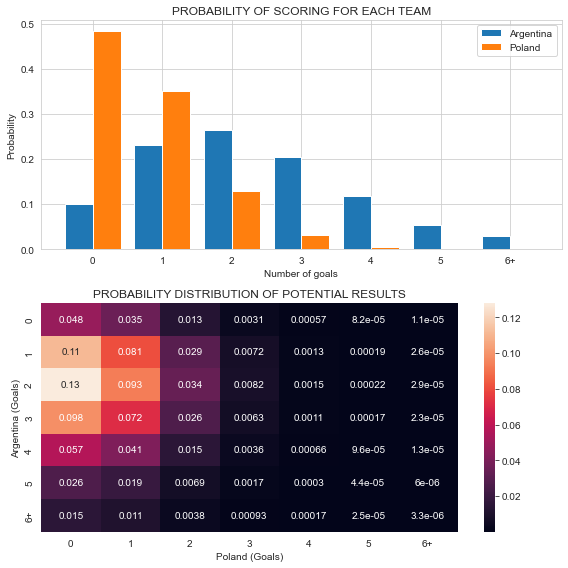


WINNING CHANCES

Argentina win_prob 0.73
Poland win_prob 0.1
Draw prob  0.17


Function parameters: Team1, Team2, start_date_inter (def='2016-11-20'), start_date_wc (def='1998-01-01')


In [18]:
match_prediction('Argentina','Poland')

---

WORKING AREA

---